In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import multiprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV


In [77]:
data = pd.read_csv('f1_cleaned.csv')
data = data.rename(columns={'driver_name' : 'team_name'})
data.drop(['code','driver_age','quali_mean'], axis=1, inplace=True)
data.dtypes

team_name         object
driver_nat        object
circuitRef        object
year             float64
round            float64
starting_pos     float64
finishing_pos    float64
laps             float64
driver_dnf         int64
car_dnf            int64
dtype: object

In [81]:
#train test split
#we are not using a random split here, training with pre 2024 data and trying to predict the races that occured in 2024

train = data[data.year<2024].copy()
test = data[data.year==2024].copy()

#testing set
y_test = test.pop('finishing_pos')
x_test = test

#training set
y_train = train.pop('finishing_pos')
x_train = train


In [82]:
#encoding vars and scaling data

cat_feat = ['team_name',
            'driver_nat', 
            'circuitRef']
x_num_feat = ['year',
              'starting_pos', 
              'laps', 
              'driver_dnf', 
              'car_dnf']

#scale y later if needed for a distance model

ct = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_feat), #avoid dummy var trap with OHE
    ('scx', StandardScaler(), x_num_feat)
])




In [47]:
#Lasso Model (l1)

#l1
lasso = Pipeline(steps=[
    ('preprocessing', ct),
    ('model', Lasso())
])

parameters = {
    "model__fit_intercept": [True, False],
    "model__positive": [True, False],
    "model__alpha": [.01,.1,1,10,100]
    #"model__alpha": np.arange(.1,100.1,.1)
}

scoring = {
    'r2': 'r2',
    'rmse': 'neg_root_mean_squared_error'
}

gs = GridSearchCV(lasso, parameters, scoring=scoring, refit='r2', cv=10, return_train_score=True)

gs.fit(x_train,y_train)

best_gs_model = gs.best_estimator_


y_pred = best_gs_model.predict(x_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print('R2;', r2)
print('Root Mean Squared Error:', rmse)
print('MAE;', mae)

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/p

R2; 0.6483539562228312
Root Mean Squared Error: 3.4132458879315415
MAE; 2.707466765516451


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [70]:
#Coefficents based on L1

lasso_model = best_gs_model.named_steps['model']

print('lasso coeff', lasso_model.coef_)

preprocessor = best_gs_model.named_steps['preprocessing']
ridge_model = best_gs_model.named_steps['model']


ohe = preprocessor.named_transformers_['encoder']
ohe_feature_names = ohe.get_feature_names_out(cat_feat)


feature_names = list(ohe_feature_names) + x_num_feat


coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_model.coef_
})


coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False).drop(columns='abs_coef')

print(coef_df)

lasso coeff [-0.69023211  0.85953774 -2.29902268  1.89258627  2.95958729 -0.41707672
 -3.78197143  0.4332474  -2.73732181  1.21060075  0.60323539 -0.
  0.         -0.04782938 -0.          0.35413211  0.         -0.
 -1.04775165 -0.02262061 -0.42976435  0.07894875  0.          0.
  0.22624949 -0.08189871 -0.28804756  0.          2.2459676   0.39030936
 -0.36680493  0.          0.          0.         -0.12771841 -0.
 -0.          0.51319074  0.          0.4046907  -0.          0.
  0.         -0.20090093  0.         -0.          0.          0.28923461
 -0.06421688 -0.47074735 -0.          0.02634925  0.02908187  0.
  0.05484898 -0.          0.53640104 -0.21165067 -0.         -0.0896712
  0.         -0.          0.          0.          0.          0.16971412
  0.11984637  1.84394597 -0.82457134 -0.27017908 -0.11822125  1.70568988
  2.32601218]
                     Feature  Coefficient
6         team_name_Mercedes    -3.781971
4   team_name_Manor Marussia     2.959587
8         team_name_R

In [70]:
#Ridge Model (l2)

ridge = Pipeline(steps=[
    ('preprocessing', ct),
    ('model', Ridge())
])

parameters = {
    "model__fit_intercept": [True, False],
    "model__positive": [True, False],
    "model__alpha": [.01,.1,1,10,100]
    #"model__alpha": np.arange(.1,100.1,.1)
}

scoring = {
    'r2': 'r2',
    'rmse': 'neg_root_mean_squared_error'
}

gs = GridSearchCV(ridge, parameters, scoring=scoring, refit='r2', cv=10, return_train_score=True)

gs.fit(x_train,y_train)

best_gs_model = gs.best_estimator_

y_pred = best_gs_model.predict(x_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('R2;', r2)
print('Root Mean Squared Error:', rmse)



/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/p

R2; 0.6481146385817512
Root Mean Squared Error: 3.4144071565372616


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/p

In [73]:
#Basic LR model

model = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', LinearRegression())
])

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

r2 = r2_score(y_test, y_pred)
print('R2;', r2)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', rmse)


# Add predictions and actuals back to `test`
test['pred_lr'] = y_pred
test['finishing_pos'] = y_test  # reattach actuals for ranking

# Convert actual and predicted to ranks within each race
test['actual_rank'] = test.groupby('circuitRef')['finishing_pos'].rank(method='min')
test['lr_rank'] = test.groupby('circuitRef')['pred_lr'].rank(method='min')

# Calculate MAE and R² on ranks
mae = mean_absolute_error(test['actual_rank'], test['lr_rank'])
r2 = r2_score(test['actual_rank'], test['lr_rank'])

print("Ranked MAE:", mae)
print("Ranked R²:", r2)


R2; 0.645885482931772
Root Mean Squared Error: 3.425205032443127
Ranked MAE: 2.44258872651357
Ranked R²: 0.6666574579820879


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [83]:
#Basic RF model (no tuning)

"""
cannot use regularization: Dropping year, round, driver_age, quali_mean DECREASES score slightly and leads to a less accurate model
leaving features in as a result
"""


model = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=None, ccp_alpha=0.1, min_samples_split=2, random_state=0))
])


model.fit(x_train, y_train)
y_pred = model.predict(x_test)


r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('R2;', r2)
print('Root Mean Squared Error:', rmse)


"""
R2; 0.7483253435398232
Root Mean Squared Error: 2.8875828253142792
"""


R2; 0.7474820732102505
Root Mean Squared Error: 2.8924164002441675


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


'\nR2; 0.7483253435398232\nRoot Mean Squared Error: 2.8875828253142792\n'

In [39]:
#Basic XGB model (L2 regularization, manual preprocess as pipeline was getting error)

#fit transform train
x_train = ct.fit_transform(x_train)
regressor = XGBRegressor(objective='reg:squarederror', 
                         n_estimators=20, 
                         n_jobs=multiprocessing.cpu_count(),
                         learning_rate=0.2)
regressor.fit(x_train, y_train)

#transform test
x_test = ct.transform(x_test)
y_pred = regressor.predict(x_test)

r2 = r2_score(y_test, y_pred)
print('R2;', r2)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', rmse)

"""
R2; 0.7532056212638376
Root Mean Squared Error: 2.8594488981674964
"""


R2; 0.7532056212638376
Root Mean Squared Error: 2.8594488981674964


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


'\nR2; 0.7532056212638376\nRoot Mean Squared Error: 2.8594488981674964\n'

In [25]:
#df created to compare results 

comparison_df = pd.DataFrame({
    'Team': test['team_name'],              
    'Circut': test['circuitRef'],          
    'Actual Pos': y_test,                         
    'Predicted Pos': y_pred                       
})

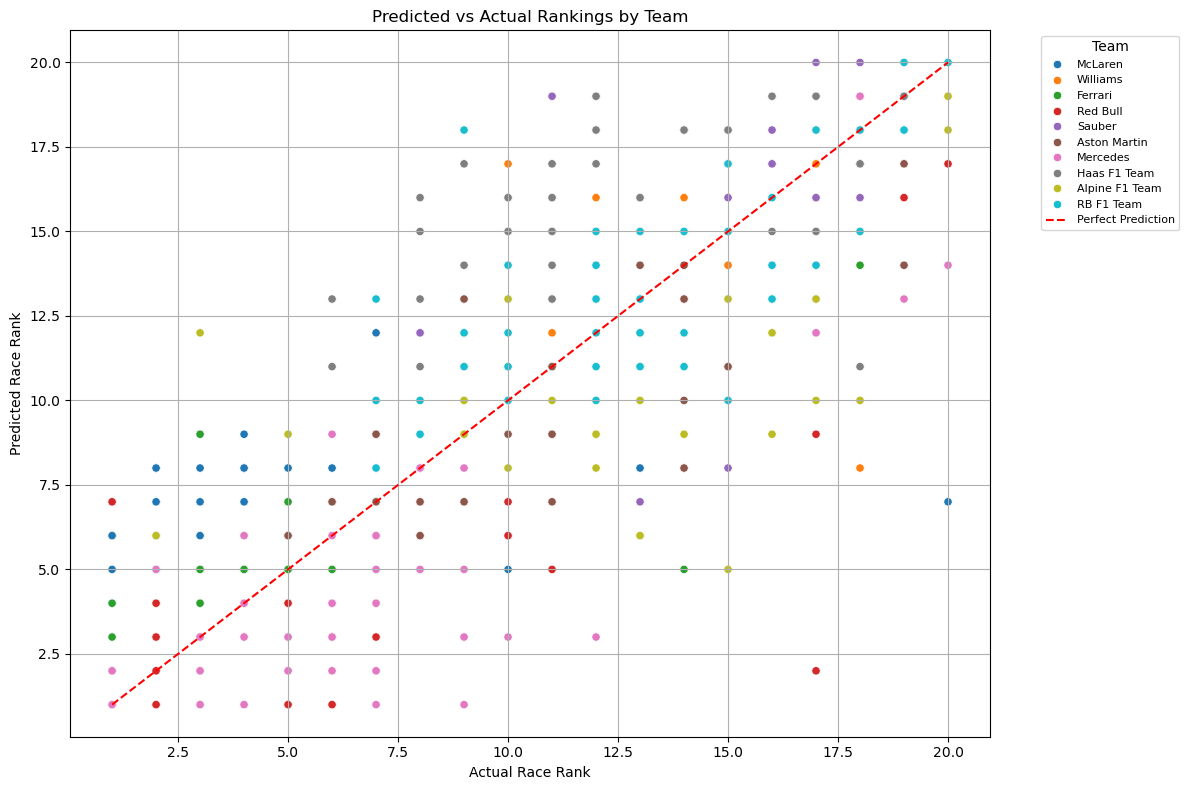

In [ ]:
test = test.copy()
test['y_pred'] = y_pred
test['y_true'] = y_test.values


test['actual_rank'] = test.groupby('circuitRef')['y_true'].rank(method='min')
test['predicted_rank'] = test.groupby('circuitRef')['y_pred'].rank(method='min')


plt.figure(figsize=(12, 8))
sns.scatterplot(x='actual_rank', y='predicted_rank', hue='team_name', data=test)

#regression line
plt.plot([1, test['actual_rank'].max()], [1, test['actual_rank'].max()], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Race Rank')
plt.ylabel('Predicted Race Rank')
plt.title('Predicted vs Actual Rankings by Team')
plt.legend(title='Team', prop={'size': 8}, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/gb/q_14btsd7vq8jrly_35pxk_m0000gn/T/ipykernel_99067/2316734073.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 8})


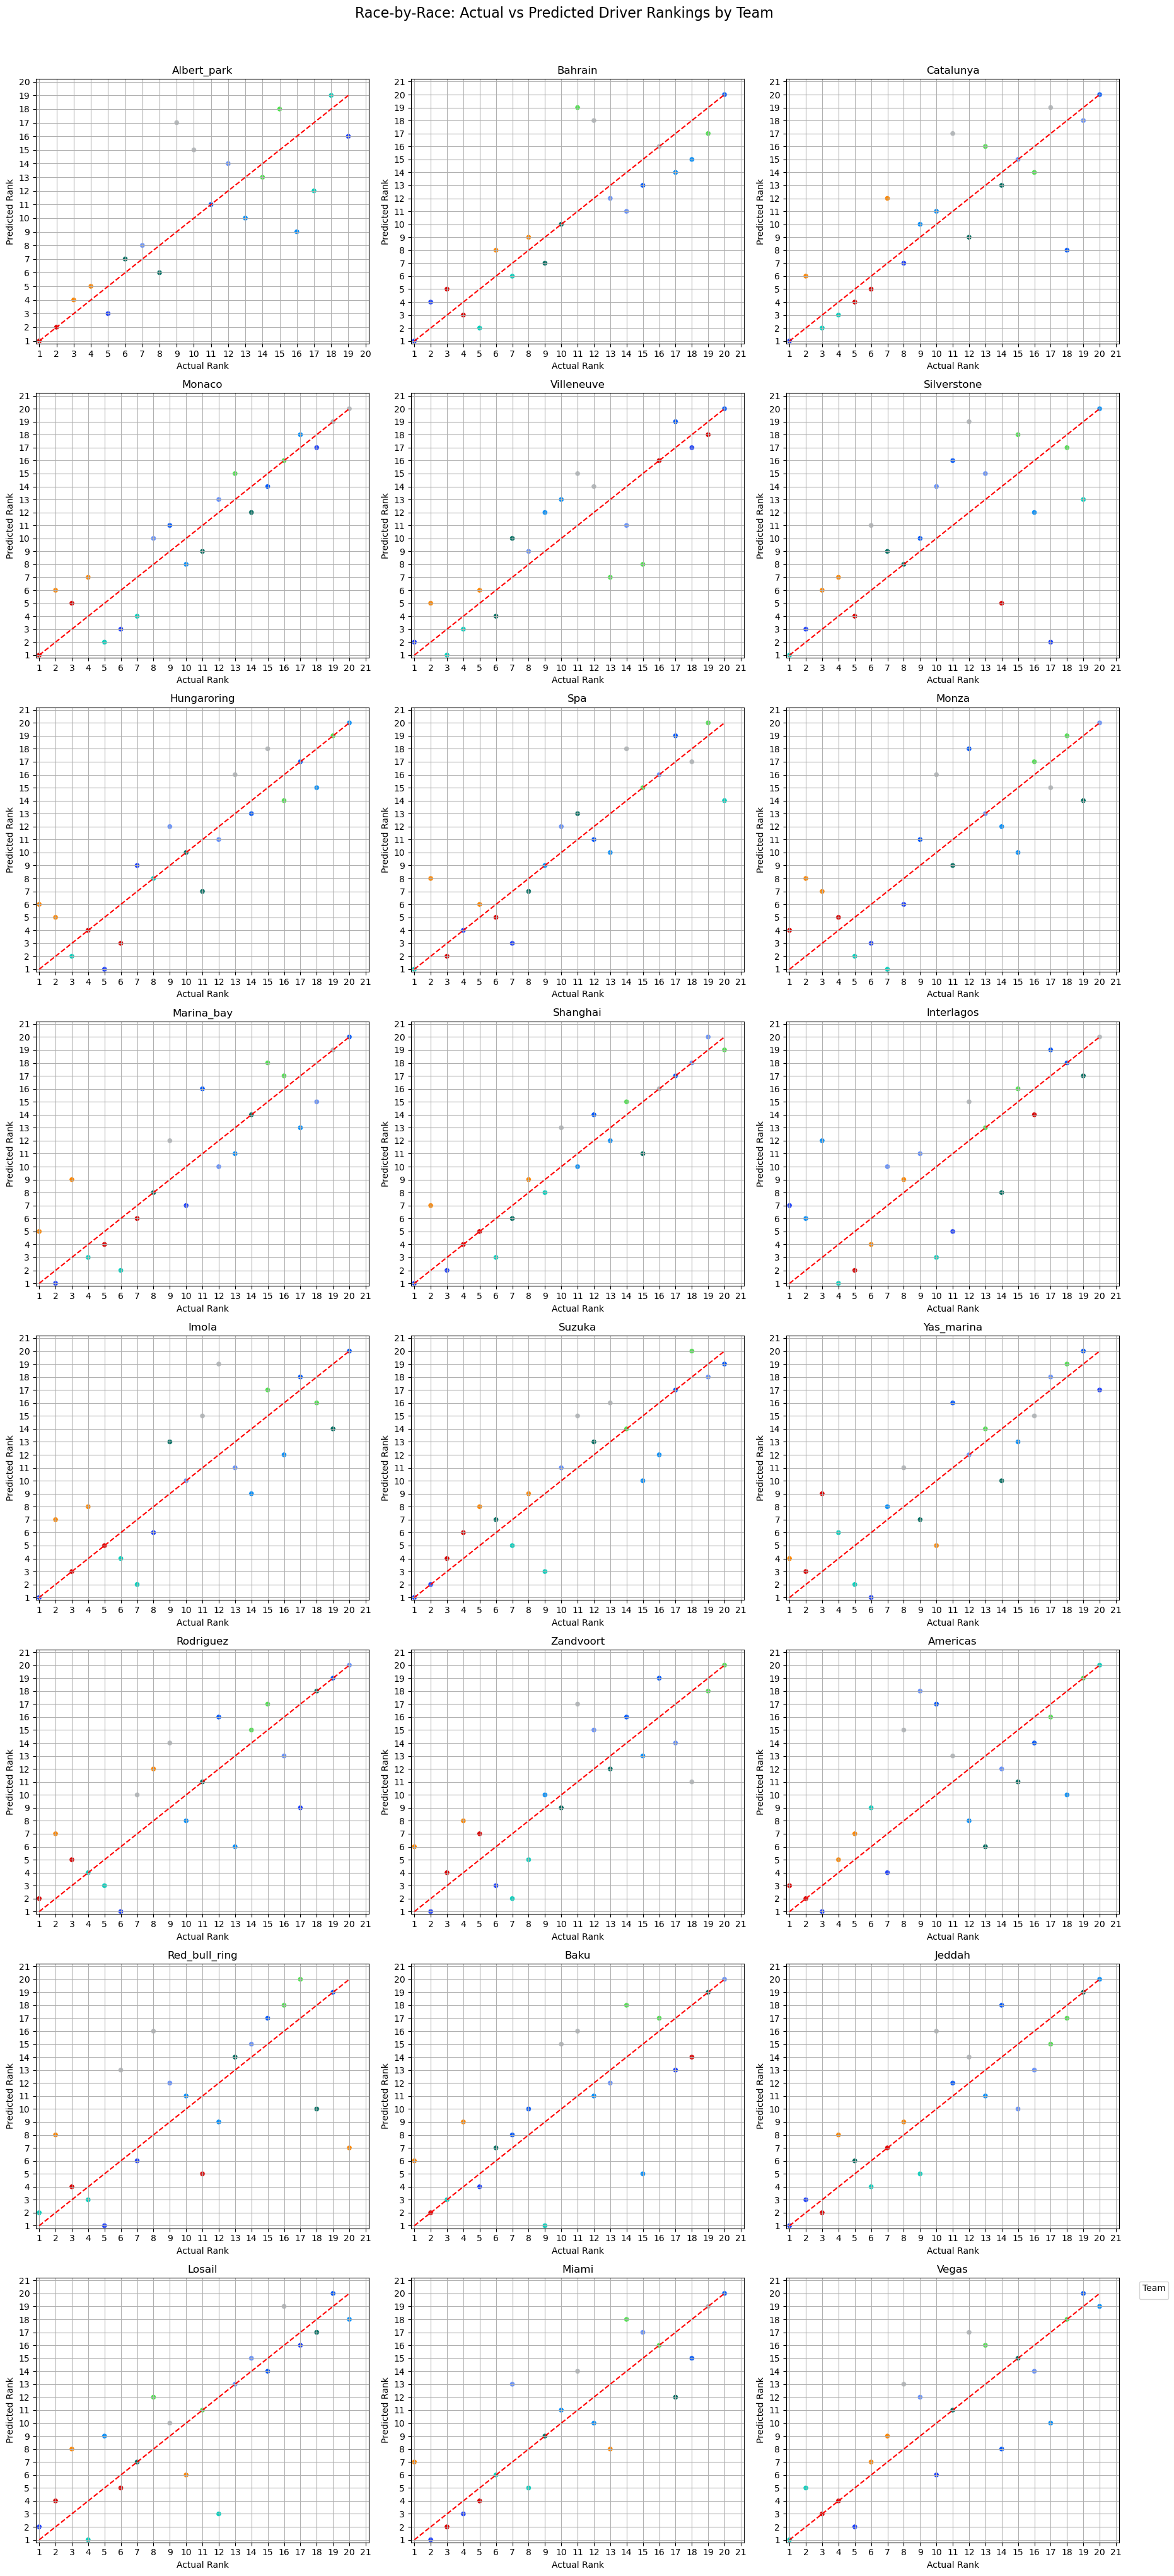

In [ ]:
#adding team colors
team_colors = {
    'Red Bull': '#1E41FF',
    'Mercedes': '#00D2BE',
    'Ferrari': '#DC0000',
    'McLaren': '#FF8700',
    'Aston Martin': '#006F62',
    'Alpine F1 Team': '#0090FF',
    'Williams': '#005AFF',
    'RB F1 Team': '#6692FF',
    'Haas F1 Team': '#B6BABD',
    'Sauber': '#52E252',
    #fallback color
    'Other': '#888888'
}
palette = {team: color for team, color in team_colors.items() if team in test['team_name'].unique()}

#getting unique races
races = test['circuitRef'].unique()
n_races = len(races)

cols = 3
rows = math.ceil(n_races / cols)

plt.figure(figsize=(6 * cols, 5 * rows))

for idx, race in enumerate(races):
    ax = plt.subplot(rows, cols, idx + 1)
    
    race_data = test[test['circuitRef'] == race]
    
    sns.scatterplot(
        x='actual_rank', 
        y='predicted_rank', 
        hue='team_name', 
        data=race_data, 
        ax=ax,
        palette=palette,
        legend=False
    )
    
    #regression line
    ax.plot([1, race_data['actual_rank'].max()], [1, race_data['actual_rank'].max()], 'r--')
    
    #scale
    max_rank = int(max(race_data['actual_rank'].max(), race_data['predicted_rank'].max())) + 1
    ax.set_xticks(range(1, max_rank + 1))
    ax.set_yticks(range(1, max_rank + 1))
    
    ax.set_xlim(0.8, max_rank + 0.2)
    ax.set_ylim(0.8, max_rank + 0.2)

    ax.set_title(f'{race.capitalize()}')
    ax.set_xlabel('Actual Rank')
    ax.set_ylabel('Predicted Rank')
    ax.grid(True)

plt.tight_layout()
plt.suptitle('Race-by-Race: Actual vs Predicted Driver Rankings by Team', fontsize=16, y=1.02)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 8})
plt.show()


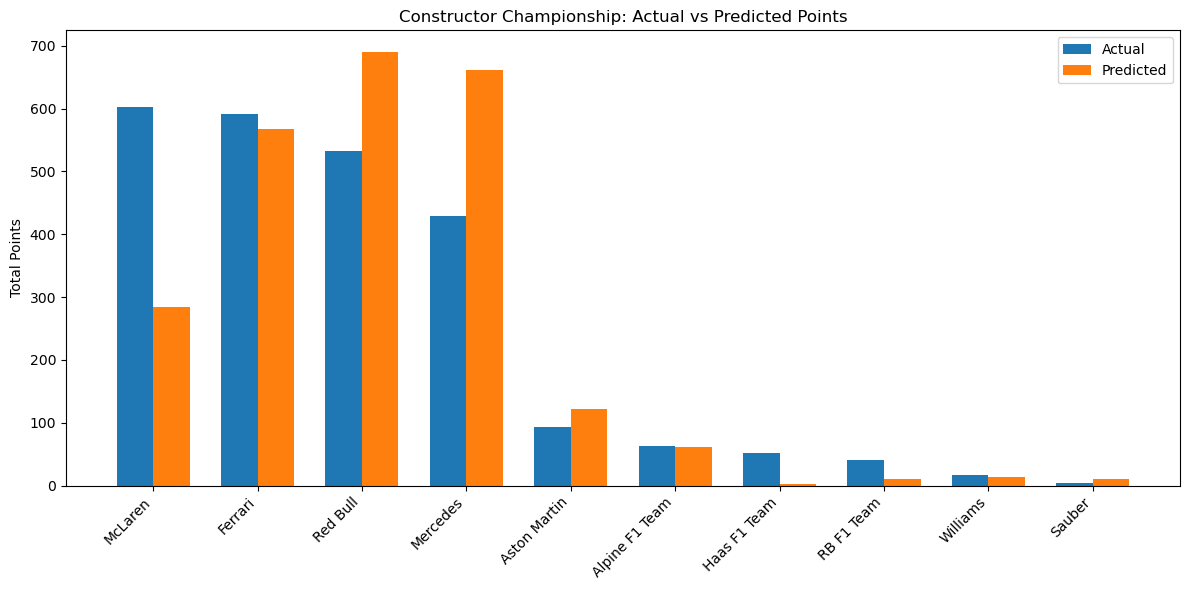

        team_name  actual_points  predicted_points
4         McLaren            603               284
2         Ferrari            591               568
7        Red Bull            533               690
5        Mercedes            429               662
1    Aston Martin             93               121
0  Alpine F1 Team             63                62
3    Haas F1 Team             51                 2
6      RB F1 Team             40                11
9        Williams             17                14
8          Sauber              4                10


In [ ]:
def position_to_points(pos):
    points_map = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10,
                  6: 8, 7: 6, 8: 4, 9: 2, 10: 1}
    return points_map.get(pos, 0)

test['actual_points'] = test['actual_rank'].apply(position_to_points)
test['predicted_points'] = test['predicted_rank'].apply(position_to_points)

team_points = test.groupby(['team_name', 'circuitRef']).agg({
    'actual_points': 'sum',
    'predicted_points': 'sum'
}).reset_index()


season_totals = team_points.groupby('team_name').agg({
    'actual_points': 'sum',
    'predicted_points': 'sum'
}).reset_index()

#sorting by actual
season_totals = season_totals.sort_values(by='actual_points', ascending=False)


teams = season_totals['team_name']
x = np.arange(len(teams))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, season_totals['actual_points'], width, label='Actual')
ax.bar(x + width/2, season_totals['predicted_points'], width, label='Predicted')

ax.set_ylabel('Total Points')
ax.set_title('Constructor Championship: Actual vs Predicted Points')
ax.set_xticks(x)
ax.set_xticklabels(teams, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

print(season_totals)
